In [50]:
import pandas as pd

data_causal = pd.read_parquet('data_causal.pt')
T0 = 50

import warnings
warnings.filterwarnings('ignore')

In [51]:
import pymc as pm
from patsy import build_design_matrices, dmatrices
import numpy as np

In [52]:
treatment_time = T0

formula = "actual ~ 1 + a + b + c + d + e + f + g + h + i"

datapre = data_causal[data_causal.index < treatment_time]
datapost = data_causal[data_causal.index >= treatment_time]

In [83]:
y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)


In [86]:
with pm.Model() as model:
    n_predictors = X.shape[1]
    X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
    y = pm.Data("y", y[:, 0], dims="obs_ind")
    # TODO: There we should allow user-specified priors here
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
    # beta = pm.Dirichlet(
    #     name="beta", a=(1 / n_predictors) * np.ones(n_predictors),
    #     dims="coeffs"
    # )
    sigma = pm.HalfNormal("sigma", 1)
    mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
    pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

In [54]:
with pm.Model() as model:
    n_predictors = X.shape[1]
    X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
    y = pm.Data("y", y[:, 0], dims="obs_ind")
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
    X_without_intercept = X[:, 1:]
    mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
    sigma = pm.HalfNormal("sigma", 1)
    pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")


In [87]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def print_pm_model_summary(trace, round_to=2):
    """
    Print the model summary with coefficient information analogous to your custom print_coefficients().
    
    This function uses ArviZ to compute summary statistics including the mean and 94% highest density interval (HDI)
    for each parameter.
    """
    # Get a summary DataFrame with a 94% HDI (i.e. quantiles at 3% and 97%)
    summary_df = az.summary(trace, round_to=round_to, hdi_prob=0.94)
    
    header = "=" * 80
    print(header)
    print("PyMC Model Summary")
    print(header)
    
    # We assume the key parameters are 'intercept', 'beta', and 'sigma'.
    # 'beta' will be printed row‐by‐row (e.g., beta[0], beta[1], …) when it is an array.
    
    # Print intercept and sigma if they exist
    for param in ["intercept", "sigma"]:
        if param in summary_df.index:
            row = summary_df.loc[param]
            print(f"{param:<12}: mean = {row['mean']:.{round_to}f}, 94% HDI = "
                  f"[{row['hdi_3%']:.{round_to}f}, {row['hdi_97%']:.{round_to}f}]")
    
    # Now print each beta coefficient. The index names should start with "beta".
    beta_rows = summary_df[summary_df.index.str.startswith("beta")]
    for index, row in beta_rows.iterrows():
        print(f"{index:<12}: mean = {row['mean']:.{round_to}f}, 94% HDI = "
              f"[{row['hdi_3%']:.{round_to}f}, {row['hdi_97%']:.{round_to}f}]")

def calculate_bayesian_r2(trace, y_true, round_to=2):
    """
    Compute a Bayesian R² based on the posterior expected values.
    
    This extracts the posterior samples for the deterministic variable 'mu' (the model prediction)
    and calculates R² by averaging across chains and draws.
    """
    # Extract 'mu' from the inference data. The shape is (chain, draw, obs_ind)
    mu_samples = trace.posterior["mu"].values  
    # Compute the predictive mean across chains and draws (collapsing the first two dimensions)
    mu_mean = mu_samples.mean(axis=(0, 1))
    r2 = r2_score(y_true, mu_mean)
    return round(r2, round_to)

with model:
    trace = pm.sample(return_inferencedata=True, random_seed=42)

print_pm_model_summary(trace, round_to=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


PyMC Model Summary
sigma       : mean = 1.82, 94% HDI = [1.47, 2.21]
beta[0]     : mean = 0.64, 94% HDI = [0.39, 0.84]
beta[1]     : mean = 0.04, 94% HDI = [0.00, 0.11]
beta[2]     : mean = 0.04, 94% HDI = [0.00, 0.11]
beta[3]     : mean = 0.04, 94% HDI = [0.00, 0.10]
beta[4]     : mean = 0.04, 94% HDI = [0.00, 0.11]
beta[5]     : mean = 0.05, 94% HDI = [0.00, 0.15]
beta[6]     : mean = 0.04, 94% HDI = [0.00, 0.12]
beta[7]     : mean = 0.04, 94% HDI = [0.00, 0.11]
beta[8]     : mean = 0.04, 94% HDI = [0.00, 0.10]
beta[9]     : mean = 0.04, 94% HDI = [0.00, 0.11]


In [88]:
summary_df = az.summary(trace, round_to=2, hdi_prob=0.94)

In [89]:
random_seed = 42


In [90]:
with model:
    model.idata = pm.sample()
    model.idata.extend(pm.sample_prior_predictive(random_seed=random_seed))
    model.idata.extend(
        pm.sample_posterior_predictive(
            model.idata, progressbar=False, random_seed=random_seed
        )
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


In [91]:
with model: 
    post_pred = pm.sample_posterior_predictive(
        model.idata,
        var_names=["y_hat", "mu"],
        progressbar=False,
        random_seed=42,
    )


Sampling: [y_hat]


In [92]:
from arviz import r2_score

In [93]:
mu.shape

Shape.0

In [94]:
pre_data = xr.DataArray(y_true, dims=["obs_ind"])
impact = pre_data - y_pred["posterior_predictive"]["y_hat"]

NameError: name 'y_true' is not defined

In [95]:
y, X = dmatrices(formula, datapre)
mu = post_pred
mu = az.extract(mu, group="posterior_predictive", var_names="mu").T.values
r2_score(y.flatten(), mu)

r2        0.028804
r2_std    0.021048
dtype: float64

### крч план кабан самому не писать а в библиотеке в weights пофиксить а вывод переменных хоть как-то но сделать, по сути пусть саммари вернет и все а дальше я сам посчитаю

In [ ]:
import pandas as pd
from causalpy import SyntheticControl
from causalpy.pymc_models import PyMCModel
from causalpy.utils import round_num

class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            has_intercept = 'Intercept' in coords.get("coeffs", [])
            if has_intercept:
                intercept = pm.Normal("intercept", mu=0, sigma=1)
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
                X_without_intercept = X[:, 1:] 
                mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
            else:
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
                mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            
            sigma = pm.HalfNormal("sigma", 1)
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")


    def print_coefficients(self, labels, round_to=None):
        """Print the model coefficients."""
        print("Model coefficients:")

        coeffs = az.extract(self.idata.posterior, var_names=["beta"])
        
        max_label_length = max(len(name) for name in labels)
        
        has_intercept = "intercept" in self.idata.posterior.variables
        
        for i, name in enumerate(labels):
            if has_intercept and name == "Intercept":
                coeff_samples = az.extract(self.idata.posterior, var_names=["intercept"])
            else:
                idx = i-1 if has_intercept else i
                coeff_samples = coeffs.isel(coeffs=idx)
            
            formatted_name = f"  {name: <{max_label_length}}"
            formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"
            print(f"  {formatted_name}  {formatted_val}")
        
        coeff_samples = az.extract(self.idata.posterior, var_names=["sigma"])
        name = "sigma"
        formatted_name = f"  {name: <{max_label_length}}"
        formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"
        print(f"  {formatted_name}  {formatted_val}")

df = pd.read_parquet('data_causal.pt')
T0 = 50
seed = 42

result_with_intercept = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

import arviz as az
az.summary(result_with_intercept.post_impact.mean("obs_ind"))

{'coeffs': ['Intercept', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], 'obs_indx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])} True


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Sampling: [beta, intercept, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-4.844,0.203,-5.244,-4.474,0.003,0.002,3594.0,3334.0,1.0


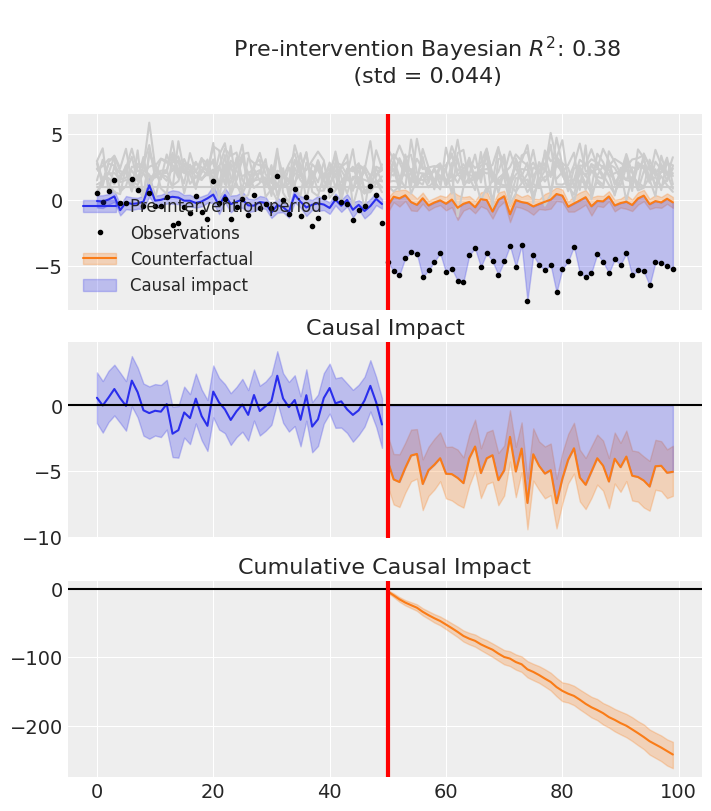

In [107]:
fig, ax = result_with_intercept.plot(plot_predictors=True)